In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets

from run_simulation import invasion_main

# Running and Visualizing One Simulation

In [2]:
months_run = 15
run_mode = 'Baseline'
simulation_df = invasion_main(run_mode, months_run) # Change this to change the number of months
# print(type(simulation_df))
simulation_df

,County,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14,Week 15
0,Cook,0.1,0.144247,0.269259,0.486765,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.0,1.000000
1,DuPage,0.0,0.078334,0.165060,0.249785,0.856747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.0,1.000000
2,Kane,0.3,0.325599,0.331140,0.468497,0.883963,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.0,1.000000
3,Will,0.0,0.041951,0.131544,0.260413,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.0,1.000000
4,Winnebago,0.0,0.082351,0.208010,0.684094,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.911891,1.000000,1.00000,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,0.000002,0.000002,0.001359,0.000629,0.001228,0.000000,0.016457,0.026068,0.075262,0.307019,0.412841,1.00000,1.0,1.0,1.000000
98,Calhoun,0.0,0.030501,0.025809,0.092056,0.114994,0.215911,0.654157,1.000000,1.000000,1.000000,1.000000,0.808431,0.96908,1.0,1.0,1.000000
99,Schuyler,0.0,0.000000,0.000199,0.001946,0.002678,0.008895,0.029502,0.027868,0.000000,0.251044,0.694070,1.000000,1.00000,1.0,1.0,1.000000
100,Gallatin,0.0,0.000023,0.000018,0.003160,0.000000,0.026247,0.051011,0.093521,0.267885,0.450452,1.000000,1.000000,1.00000,1.0,1.0,0.820347


In [3]:
def make_visual_df(simulation_df):
    visual_df = simulation_df.T
    visual_df.columns = visual_df.iloc[0]
    visual_df = visual_df.drop(visual_df.index[0])
    return visual_df

visual_df = make_visual_df(simulation_df)
visual_df

County,Cook,DuPage,Kane,Will,Winnebago,Lake,McHenry,St. Clair,Kendall,Madison,...,Scott,Stark,Jasper,Hamilton,Pike,Henderson,Calhoun,Schuyler,Gallatin,Pope
Week 0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Week 1,0.144247,0.078334,0.325599,0.041951,0.082351,0.008613,0.158288,0.03098,0.053122,0.510782,...,0.003258,0.001393,0.0,0.000387,0.001417,0.000002,0.030501,0.0,0.000023,0.0
Week 2,0.269259,0.16506,0.33114,0.131544,0.20801,0.434878,0.400648,0.111268,0.154181,0.519121,...,0.062104,0.000185,0.000349,0.0,0.010088,0.000002,0.025809,0.000199,0.000018,0.0
Week 3,0.486765,0.249785,0.468497,0.260413,0.684094,0.625076,0.705694,0.338937,0.33796,0.542348,...,0.074383,0.003015,0.003188,0.006993,0.029104,0.001359,0.092056,0.001946,0.00316,0.0
Week 4,1.0,0.856747,0.883963,1.0,1.0,1.0,1.0,0.410722,1.0,0.600935,...,0.097569,0.011482,0.0,0.040407,0.06855,0.000629,0.114994,0.002678,0.0,0.000181
Week 5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6868,1.0,0.866164,...,0.196714,0.039719,0.001225,0.064604,0.152992,0.001228,0.215911,0.008895,0.026247,0.001902
Week 6,1.0,1.0,1.0,1.0,1.0,0.916778,1.0,0.663694,1.0,1.0,...,0.120053,0.681266,0.097216,0.12149,0.265907,0.0,0.654157,0.029502,0.051011,0.013333
Week 7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.896136,1.0,1.0,...,0.490578,1.0,0.409629,0.239477,0.381479,0.016457,1.0,0.027868,0.093521,0.033023
Week 8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.417927,1.0,0.654126,0.411267,0.854884,0.026068,1.0,0.0,0.267885,0.03317
Week 9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.868335,0.759949,1.0,0.075262,1.0,0.251044,0.450452,0.02515


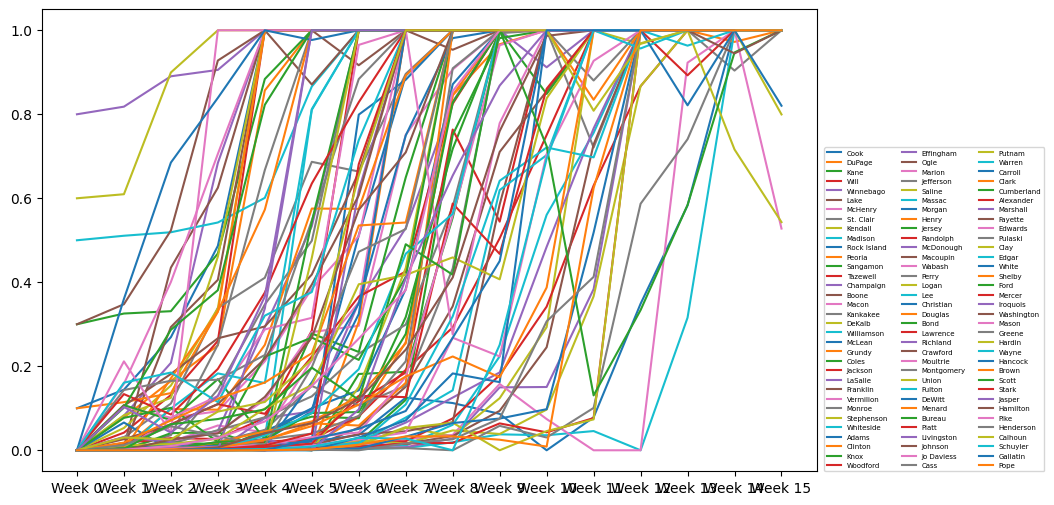

In [4]:
plt.figure(figsize=(10,6))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=5, ncol=3)
plt.show()

In [5]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [6]:
def make_network_heat(month):
    month = f'month {month}'
#     min_value = simulation_df[month].min()
#     max_value = simulation_df[month].max()  # This makes the scale variable for each chart
    max_value = 1  # This keeps the scale constant 
    min_value = 0
    cmap = matplotlib.colormaps['YlOrRd']

    node_colors = {}
    for node in CG.nodes():
        value = simulation_df.loc[simulation_df['County'] == node.name, month].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)
        
    labels = {node: handler[node.name].name for node in CG.nodes()}
    fig, ax = plt.subplots(figsize=(10, 15))
    node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
    nx.draw(CG, 
            pos=node_positions,
            ax=ax, 
            node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
            node_size=1500, )

    nx.draw_networkx_labels(CG, 
                            pos=node_positions, 
                            labels=labels,
                            font_size=6, 
                            ax=ax,
                           font_color='k')
    
    edge_colors = ['gray' if CG[src][tgt]['rel'] == 'interstate' else 'k' for src, tgt in CG.edges()]
    edge_widths = [5 if CG[src][tgt]['rel'] == 'interstate' else 1 for src, tgt in CG.edges()]
    nx.draw_networkx_edges(CG, pos=node_positions, edge_color=edge_colors, ax=ax, width=edge_widths)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    sub_ax = plt.axes([0.96, 0.55, 0.02, 0.3])
    plt.colorbar(sm, cax=sub_ax)
    plt.show()

In [7]:
widgets.interact(make_network_heat,
    month=widgets.IntSlider(min=0, max=len(simulation_df.columns)-2, step=1, layout=widgets.Layout(width='800px')),
)

interactive(children=(IntSlider(value=0, description='week', layout=Layout(width='800px'), max=15), Output()),…

<function __main__.make_network_heat(week)>

In [8]:
# This doesn't work very well for me since the page keeps re-centering

play = widgets.interact(make_network_heat, 
    month=widgets.Play( value=0,
                        min=0,
                        max=len(simulation_df.columns) - 2,
                        step=1,
                        interval=500,
                        disabled=False
                    ))

interactive(children=(Play(value=0, description='week', interval=500, max=15), Output()), _dom_classes=('widge…

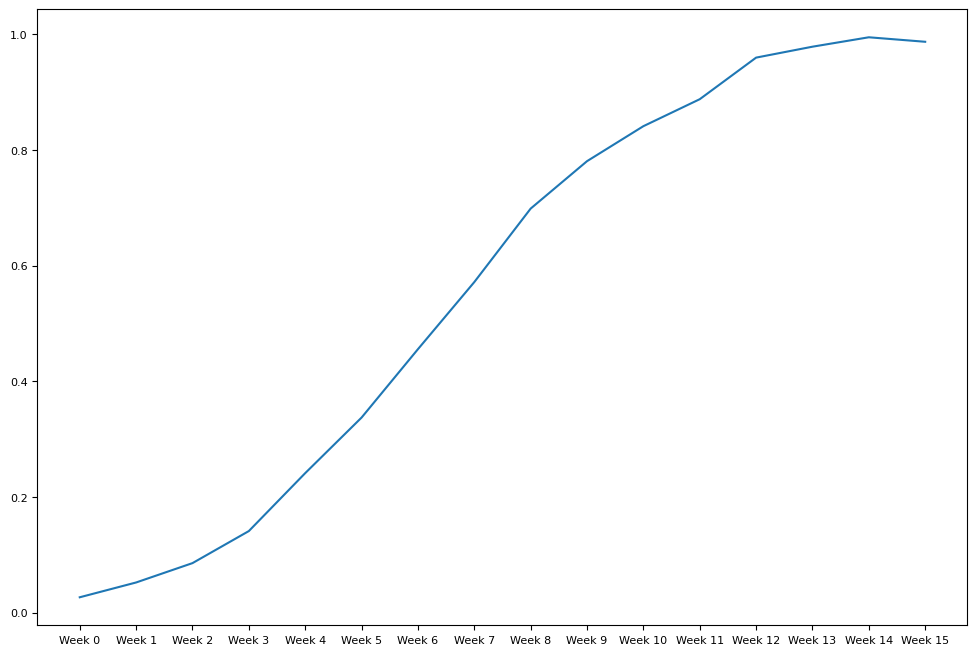

In [9]:
avg_df = visual_df.mean(axis=1)
plt.figure(figsize=(12,8))
plt.plot(avg_df.index, avg_df.iloc[0:, ])
plt.tick_params(labelsize=8)

# Repeating the Simulation and Plotting the Results

In [10]:
def make_average_graphs(df):
    vis_df = make_visual_df(df)
    avg_df = vis_df.mean(axis=1)
    plt.plot(avg_df.index, 
             avg_df.iloc[0:, ],
             linewidth=0.5)

In [11]:
def model_variables(run_mode, sims_run, sim_months):
    plt.figure(figsize=(12,8))
    plt.tick_params(labelsize=8)
    
    for i in range(0, sims_run):
        df = invasion_main(run_mode, sim_months)
        make_average_graphs(df)
    
    plt.show()

sims_run = 50  # RIP my RAM
sim_months = 15

# model_variables('Baseline', sims_run, sim_months)

# Model Variables

In [19]:
# widgets.interact(model_variables,
#     run_mode =['Baseline', 'Poison ToH', 'Population-Based Countermeasures', 'Quarantine'],
#     sims_run = (10, 50, 10),
#     sim_months = (1, 30, 1),
#     value='Baseline',
#     disabled=False,

# )

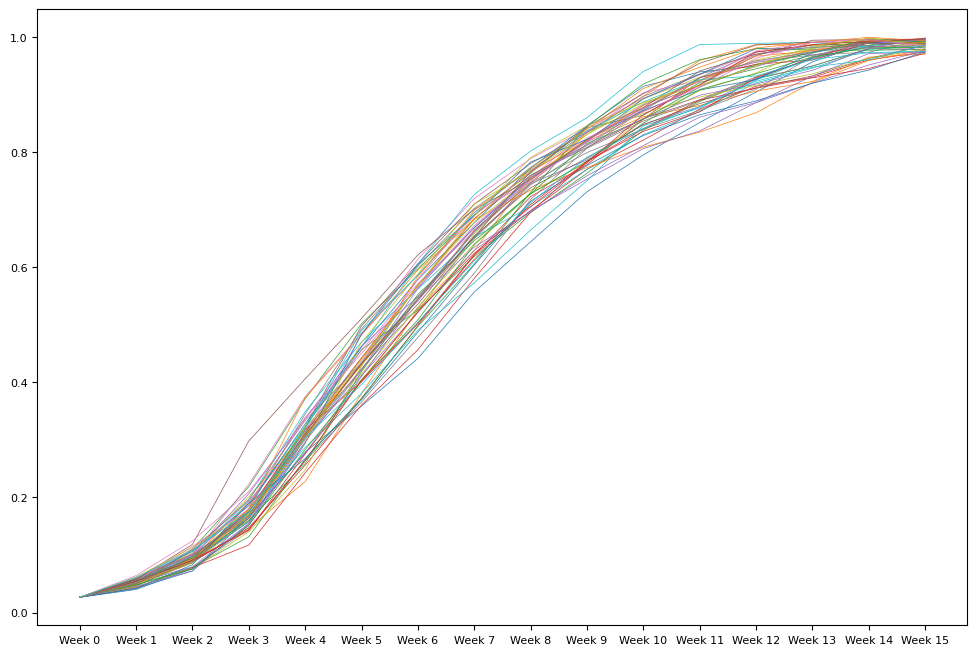

In [13]:
model_variables('Baseline', sims_run, sim_months)

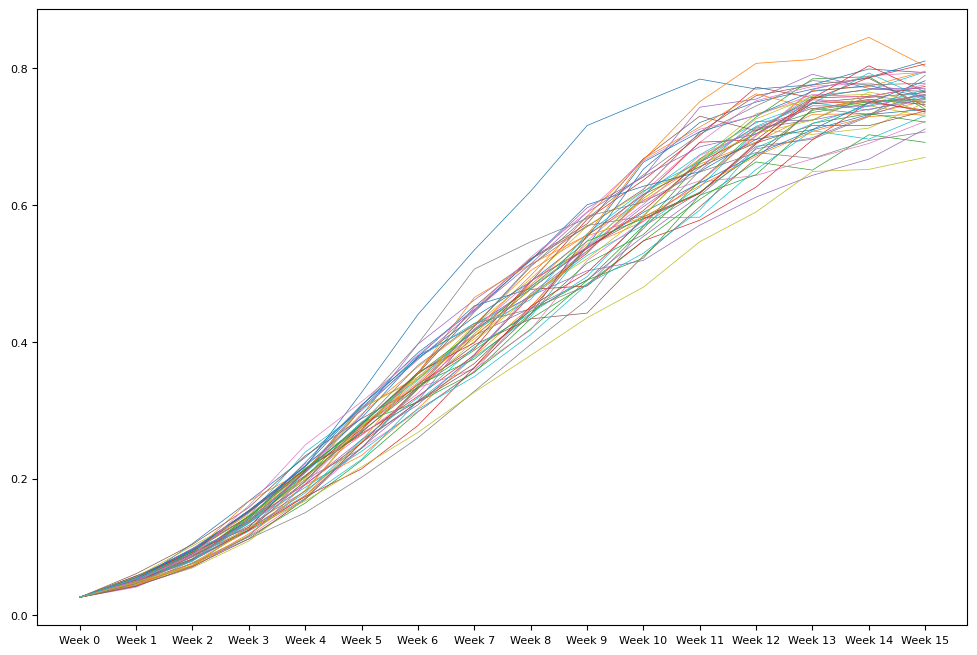

In [21]:
model_variables('Poison ToH', sims_run, sim_months)

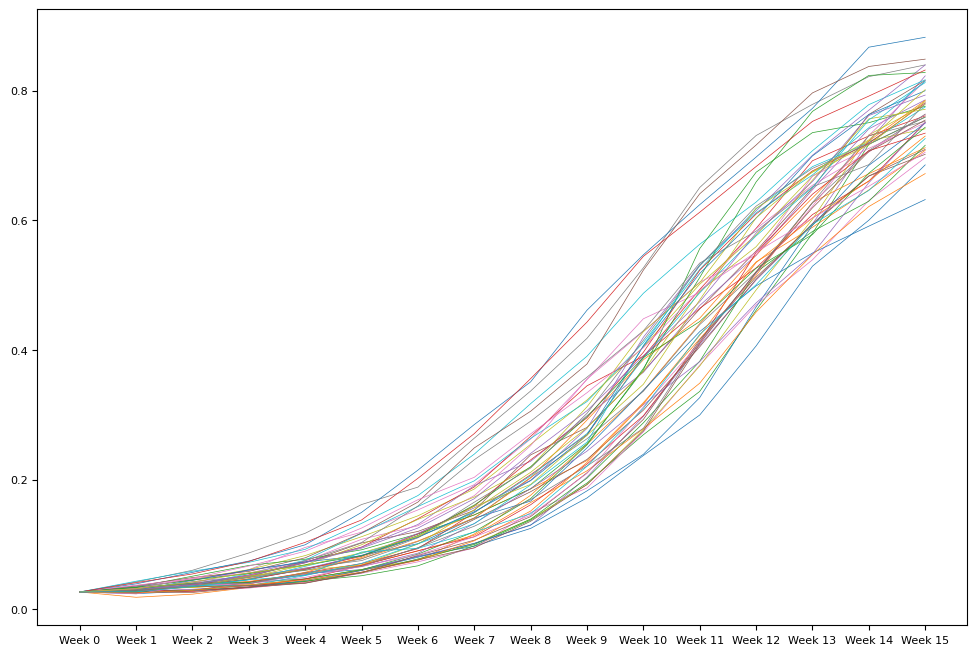

In [15]:
model_variables('Population-Based Countermeasures', sims_run, sim_months)

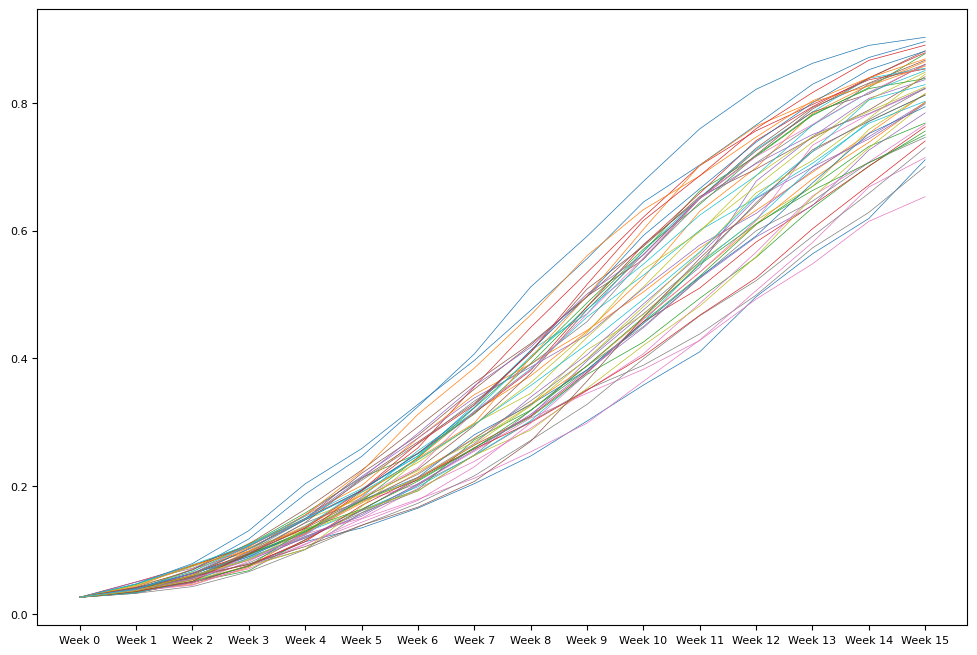

In [16]:
model_variables('Quarantine', sims_run, sim_months)

In [17]:
# import seaborn as sns
# import numpy as np
# for i in range(100):
#     print(np.random.choice([True, False]))
#     # print(np.random.normal(0.3, 0.1) * 0.01)
# # sns.kdeplot(np.random.normal(0.5, 0.8))